In [1]:
import sys
sys.path.append('/vera/u/olwitt/illustris_python/illustris_python')
from loadMPBs import loadMPBs

import time
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import h5py
import numba as nb
from numba import jit, njit
import tracerFuncs as tF
import insituFuncs as iF
import matplotlib as mpl
import time

plt.style.use('default')
plt.rcParams["figure.figsize"][0] = 16
plt.rcParams["figure.figsize"][1] = 9
plt.rcParams['errorbar.capsize']=2

In [2]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-2/output'
h_const=il.groupcat.loadHeader(basePath,99)['HubbleParam']
boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize']

In [4]:
f = h5py.File(basePath[:-6]+'postprocessing/StellarAssembly/galaxies_099.hdf5','r')
stellar_mass = f['StellarMassTotal'][:]
exsitu_stellar_mass = f['StellarMassExSitu'][:]
frac = exsitu_stellar_mass[np.where(stellar_mass>0)[0]] / stellar_mass[np.where(stellar_mass>0)[0]]
stellar_mass = np.log10(stellar_mass[np.where(stellar_mass>0)[0]] * 1e10/h_const)
f.close()

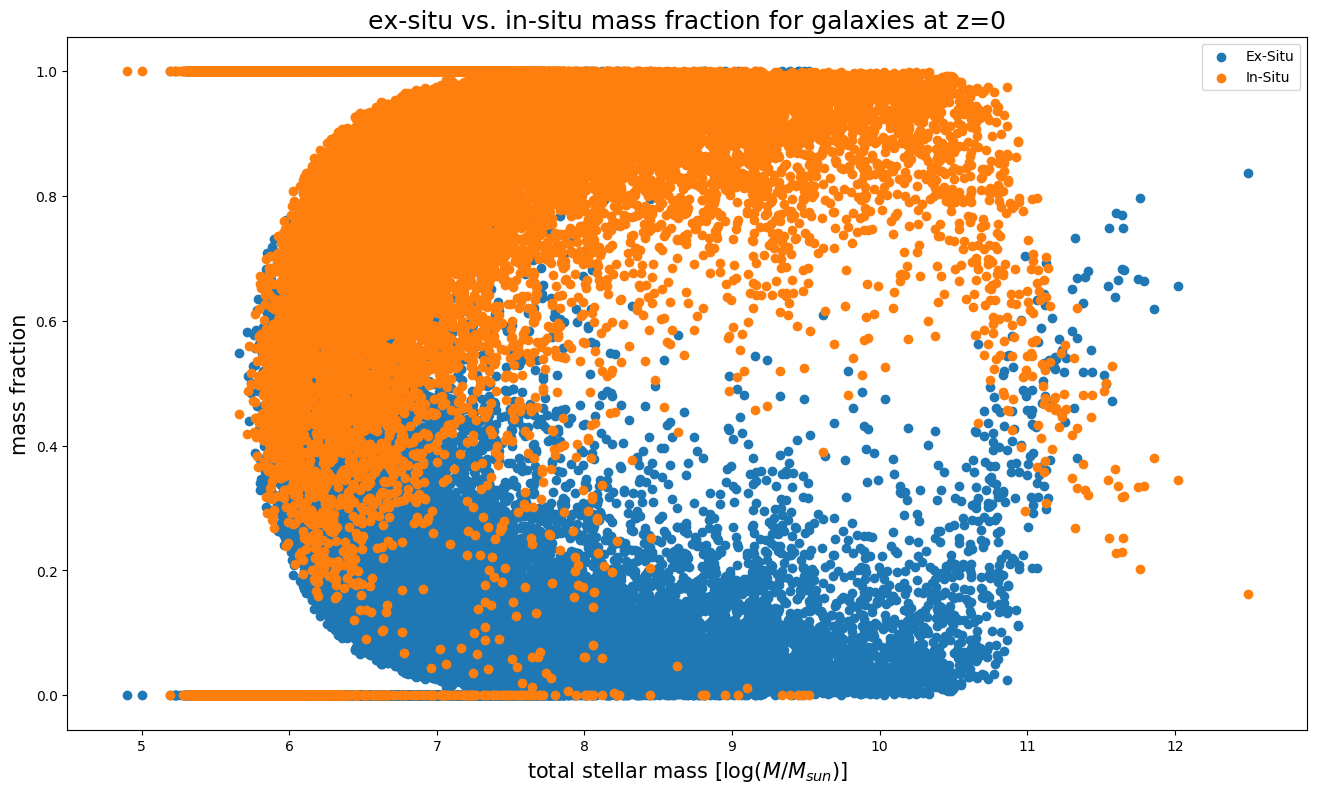

In [5]:
plt.scatter(stellar_mass,frac,label='Ex-Situ')
plt.scatter(stellar_mass,1-frac,label='In-Situ')
plt.ylabel('mass fraction',size=15)
plt.xlabel('total stellar mass [$\log(M/M_{sun})$]',size=15)
plt.title('ex-situ vs. in-situ mass fraction for galaxies at z=0',size=18)
plt.legend()
#plt.savefig('pics/ex-in-situ_mass_frac_z0_50-2.jpg',format = 'jpg')

In [17]:
def AllTracerProfile_wMassBins(basePath, start_snap, target_snap, onlyGas = False):
    header = il.groupcat.loadHeader(basePath,target_snap)
    redshift = header['Redshift']
    h_const = header['HubbleParam']
    boxSize = header['BoxSize']
    
    parent_indices = h5py.File('files/'+basePath[32:39]+'/all_parent_indices.hdf5','r')
    sub_positions = h5py.File('files/'+basePath[32:39]+'/SubhaloPosAtAllSnaps_extrapolated.hdf5','r') 
    is_extrapolated = sub_positions['is_extrapolated'][:]
    
    sub_means = np.zeros(np.where(is_extrapolated)[0].shape)
    
    #print(np.where(is_extrapolated==False)[0])
    #possibly, the position at that snapshot had to be extrapolated
    
    sub_pos_at_target_snap = sub_positions['SubhaloPos'][:,:,:]
    num_subs = sub_pos_at_target_snap.shape[0]

    parent_indices_data = parent_indices[f'snap_0{target_snap}/parent_indices'][:,:]
    tracers_in_parent_offset = parent_indices[f'snap_0{target_snap}/tracers_in_parents_offset'][:]
    
    all_gas_pos = il.snapshot.loadSubset(basePath,target_snap,'gas',fields=['Coordinates'])
    if not onlyGas:
        all_star_pos = il.snapshot.loadSubset(basePath,target_snap,'stars',fields=['Coordinates'])
    
    #introduce stellar mass bins:
    sub_masses = il.groupcat.loadSubhalos(basePath,start_snap,fields=['SubhaloMassType'])[:,4] * 1e10/h_const
    
    #mass_bin1 = np.where(np.logical_and(sub_masses > 0, sub_masses < 1e9))[0]
    mass_bin1 = np.where(np.logical_and(sub_masses >= 1e9,sub_masses < 10**(9.5)))[0]
    mass_bin2 = np.where(np.logical_and(sub_masses >= 10**(9.5),sub_masses < 10**(10.0)))[0]
    mass_bin3 = np.where(np.logical_and(sub_masses >= 10**(10.0),sub_masses < 10**(10.5)))[0]
    mass_bin4 = np.where(sub_masses >= 10**(10.5))[0]
    num_mass_bins = 4
    
    insituStarsInSubOffset = tF.insituStarsInSubOffset(basePath,target_snap)
    
    #there might be more tracers -> parents in one galaxy at higher redshifts than insitu stars at redshift 0
    final_offsets = tF.tracersInSubhalo(insituStarsInSubOffset,tracers_in_parent_offset).astype(int)
    
    counter = 0
    num_bins = 100
    bins = np.zeros((num_mass_bins,num_bins))
    num = np.zeros((num_mass_bins,num_bins))
    mass_means = np.zeros(num_mass_bins)
    numPerBin = np.zeros(num_mass_bins)
    data_bins = np.linspace(0,30000,num_bins)
    
    for i in range(num_mass_bins):
        mass_rad_profile = np.zeros(1)
        bin_counter = 0
        for index in locals()["mass_bin"+str(i+1)]:
            if is_extrapolated[index]:
                parent_indices_of_sub = parent_indices_data[final_offsets[index-1]:final_offsets[index],:]
                
                gas_parent_indices = parent_indices_of_sub[np.where(parent_indices_of_sub[:,1] == 0)[0],0]
                gas_pos = all_gas_pos[gas_parent_indices.astype(int)]
                
                if not onlyGas:
                    star_parent_indices = parent_indices_of_sub[np.where(parent_indices_of_sub[:,1] == 1)[0],0]
                    star_pos = all_star_pos[star_parent_indices.astype(int)]
                    
                subhalo_position = sub_pos_at_target_snap[index,start_snap-target_snap,:]
                
                rad_dist = np.zeros(gas_pos.shape[0])
                if not onlyGas:
                    rad_dist = np.zeros(gas_pos.shape[0] + star_pos.shape[0])
                for j in range(gas_pos.shape[0]):
                    rad_dist[j] = iF.dist(subhalo_position,gas_pos[j],boxSize)
                if not onlyGas:
                    for j in range(star_pos.shape[0]):
                        rad_dist[gas_pos.shape[0] + j] = iF.dist(subhalo_position,star_pos[j],boxSize)
                    
                mass_rad_profile = np.concatenate((mass_rad_profile,rad_dist))
                mass_rad_profile = mass_rad_profile[np.where(mass_rad_profile<boxSize)[0]]
                
                if rad_dist.shape[0]>0:
                    sub_means[counter] = np.mean(rad_dist)
                else:
                    sub_means[counter] = 0
                counter+=1
                bin_counter+=1
                
        mass_rad_profile = np.delete(mass_rad_profile,0) # delete 0 from initialization in line 49
        #compute mean distance for each mass bin
        mass_means[i] = np.mean(mass_rad_profile)
        num[i,:] = iF.binData_w_bins(mass_rad_profile,data_bins)
        numPerBin[i] = bin_counter
        
    for k in range(num_mass_bins):
        num[k,:]=num[k,:]/sum(num[k,:])
    parent_indices.close()
    sub_positions.close()
    return data_bins, num, mass_means, sub_means, numPerBin

In [24]:
%%time
basePath='/virgotng/universe/IllustrisTNG/TNG50-2/output'
bins, num, mass_means, sub_means, numPerBin = AllTracerProfile_wMassBins(basePath,99,99,onlyGas = False)

(2,)
CPU times: user 7min 16s, sys: 54 s, total: 8min 10s
Wall time: 9min 1s


In [18]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-4/output'
snaps = np.array([84,67,50,33,25])
z = np.zeros(snaps.size)
for i in range(snaps.size):
    z[i] = il.groupcat.loadHeader(basePath,snaps[i])['Redshift']

bins = np.zeros(1)
num = np.zeros((snaps.size,4,100))
for i in range(snaps.size):
    if i==0:
        bins, num[i,:,:],_,_,_ = AllTracerProfile_wMassBins(basePath,99,snaps[i],onlyGas = False)
    else:
        _, num[i,:,:],_,_,_ = AllTracerProfile_wMassBins(basePath,99,snaps[i],onlyGas = False)

In [15]:
# f = h5py.File('files/TNG50-2/rad_prof_mass_bins_tracer_frac.hdf5','w')
# ds = f.create_dataset('bins',data = bins)
# ds2 = f.create_dataset('redshift',data = z)
# ds3 = f.create_dataset('values',data = num)
# f.close()

In [6]:
f = h5py.File('files/TNG50-2/rad_prof_mass_bins_tracer_frac-400.hdf5','r')
bins = f['bins'][:]
z = f['redshift'][:]
num = f['values'][:,:,:]
f.close()

basePath='/virgotng/universe/IllustrisTNG/TNG50-2/output'
snaps = np.array([84,67,50,33,25])

TNG50-4


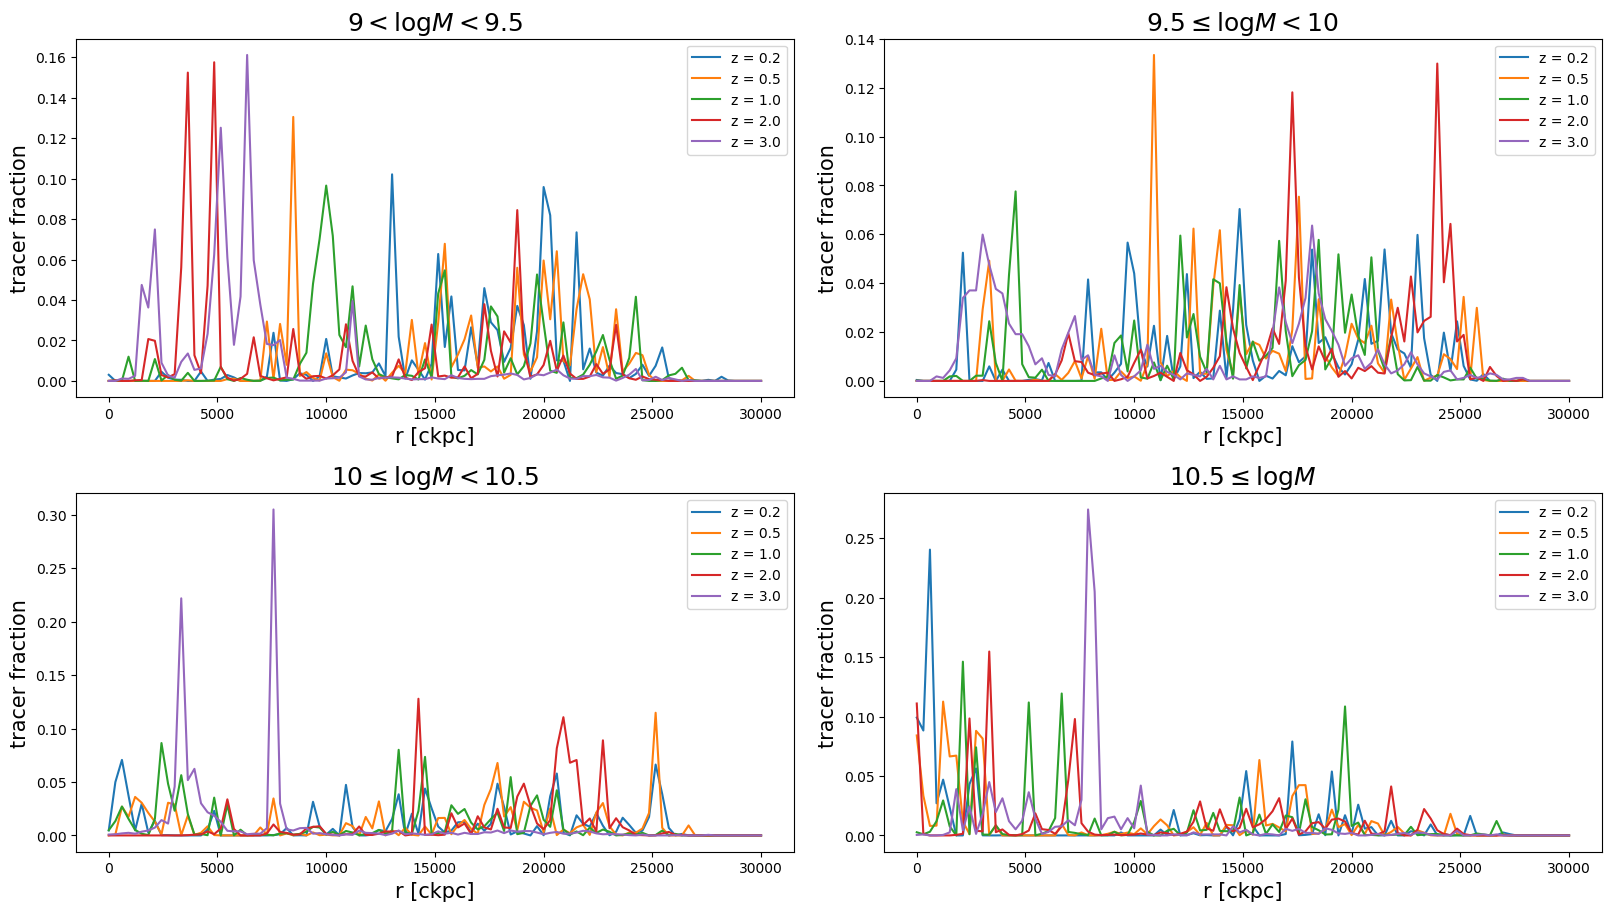

In [20]:
fig, ax = plt.subplots(2,2,constrained_layout=True)
mask1 = (0,0)
mask2 = (0,1)
mask3 = (1,0)
mask4 = (1,1)
for i in range(snaps.size):
    for b in range(4):
        h = locals()['mask'+str(b+1)]
        ax[h].plot(bins,num[i,b,:],label = f'z = {z[i]:.1f}')
        
for b in range(4):
    h = locals()['mask'+str(b+1)]
    ax[h].legend()
    ax[h].set_xlabel('r [ckpc]',size=15)
    ax[h].set_ylabel('tracer fraction',size=15)
ax[0,0].set_title('$9 < \log{M} < 9.5$',size=18)
ax[0,1].set_title('$9.5 \leq \log{M} < 10$',size=18)
ax[1,0].set_title('$10\leq\log{M} < 10.5$',size=18)
ax[1,1].set_title('$10.5\leq\log{M}$',size=18)
print(basePath[32:39])

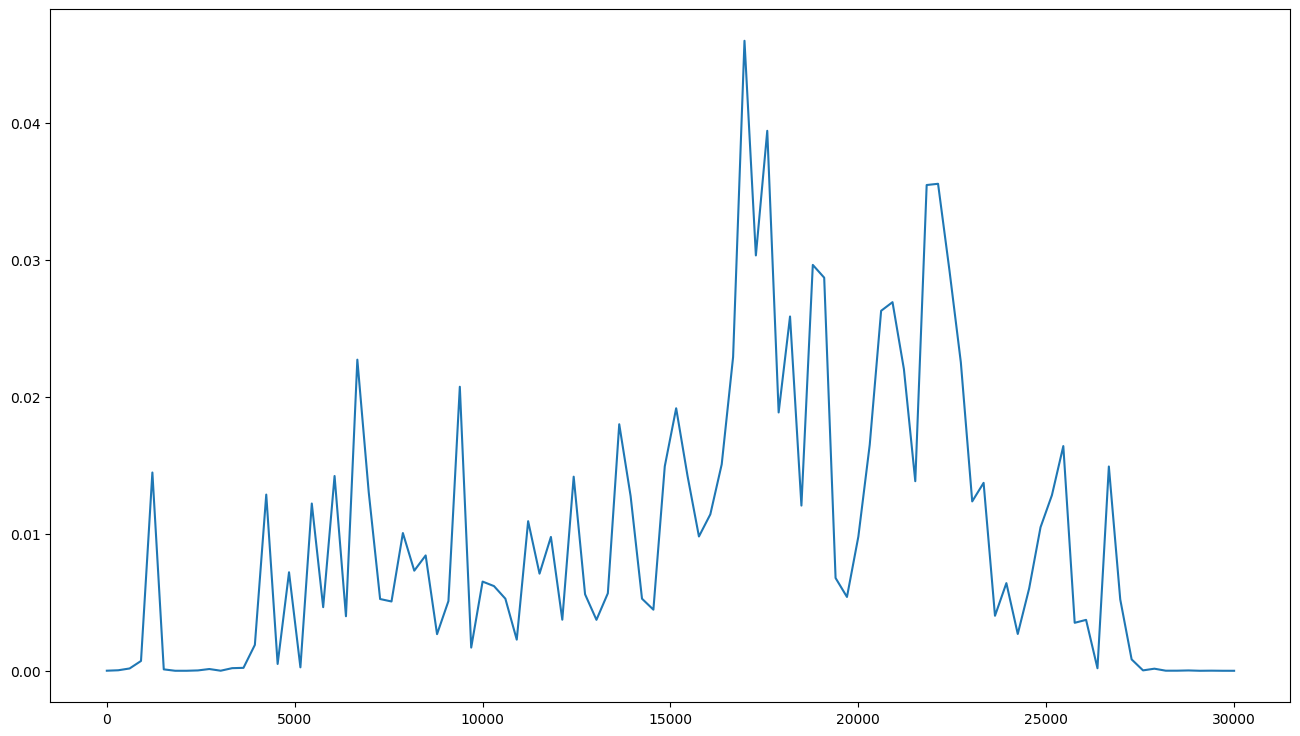

In [11]:
plt.plot(bins,num[0,0,:])

In [24]:
@njit
def running_median(y,size):
    if size>y.shape[0]:
        return None
    med = np.zeros(y.shape[0])
    for i in range(int(size/2) , y.shape[0]-int(size/2)):
        #if i > int(size/2) and i < y.shape[0] - int(size/2):
        med[i] = np.median(y[i-int(size/2):i+int(size/2)])
        #elif i > y.shape[0] - int(size/2):
            #med[i] = np.median(y[i-int(size/2):])
        #else:
            #med[i] = np.median(y[:i+int(size/2)])
    return med

In [30]:
def RunningMedian_v2(x,N):
    idx = np.arange(N) + np.arange(len(x)-N+1)[:,None]
    b = [row[row>0] for row in x[idx]]
    return np.array([np.median(c) for c in b])

In [36]:
from collections import deque
from bisect import insort, bisect_left
from itertools import islice
def running_median_insort(seq, window_size):
    """Contributed by Peter Otten"""
    seq = iter(seq)
    d = deque()
    s = []
    result = []
    for item in islice(seq, window_size):
        d.append(item)
        insort(s, item)
        result.append(s[len(d)//2])
    m = window_size // 2
    for item in seq:
        old = d.popleft()
        d.append(item)
        del s[bisect_left(s, old)]
        insort(s, item)
        result.append(s[m])
    return result

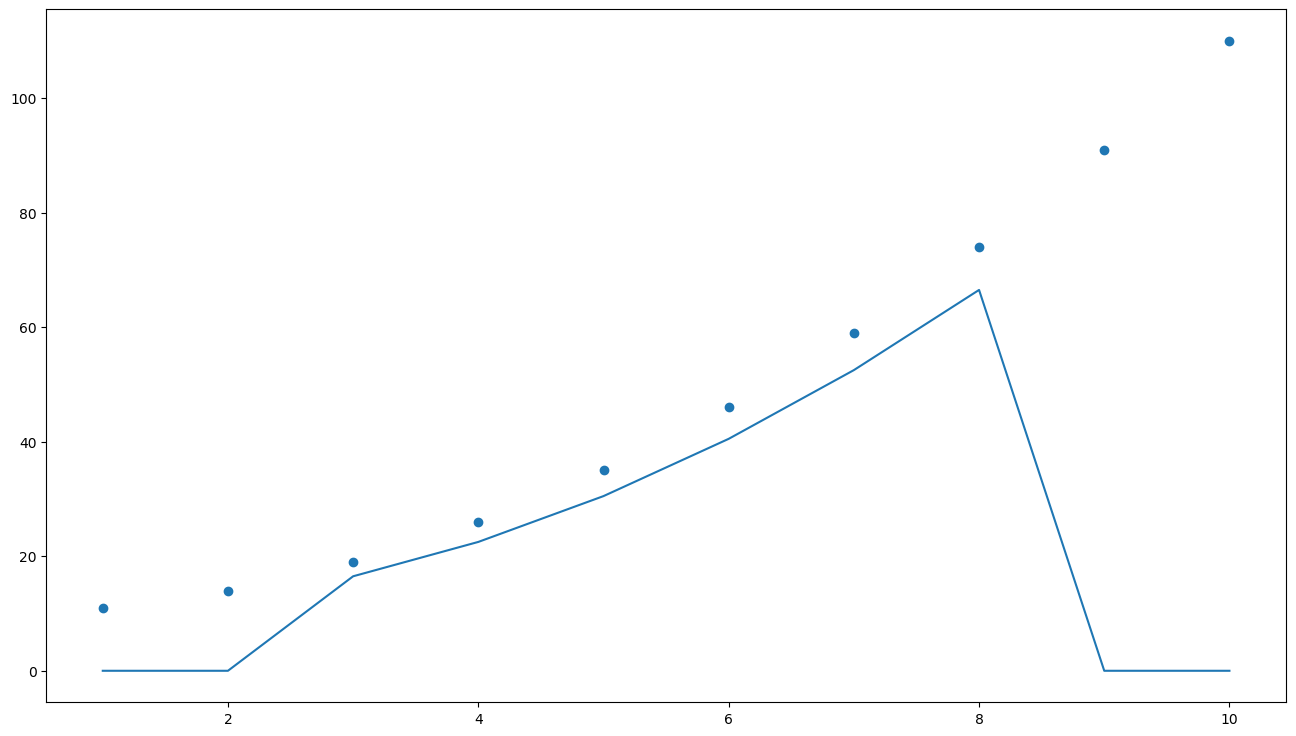

In [45]:
x = np.arange(1,11)
y = x**2 + 10
plt.scatter(x,y)
plt.plot(x,running_median(y,size = 4))

In [45]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-4/output'
snaps = np.array([84,67,50,33,25])
z = np.zeros(snaps.size)
for i in range(snaps.size):
    z[i] = il.groupcat.loadHeader(basePath,snaps[i])['Redshift']

sub_means0 = np.zeros(1)
sub_means1 = np.zeros(1)
sub_means2 = np.zeros(1)
sub_means3 = np.zeros(1)
sub_means4 = np.zeros(1)
for i in range(snaps.size):
    _, _, _, locals()['sub_means'+str(i)], _ = AllTracerProfile_wMassBins(basePath, 99, snaps[i], onlyGas = True)

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Lagrangian distance of gas producing in-situ stars by z=0 vs. stellar mass')

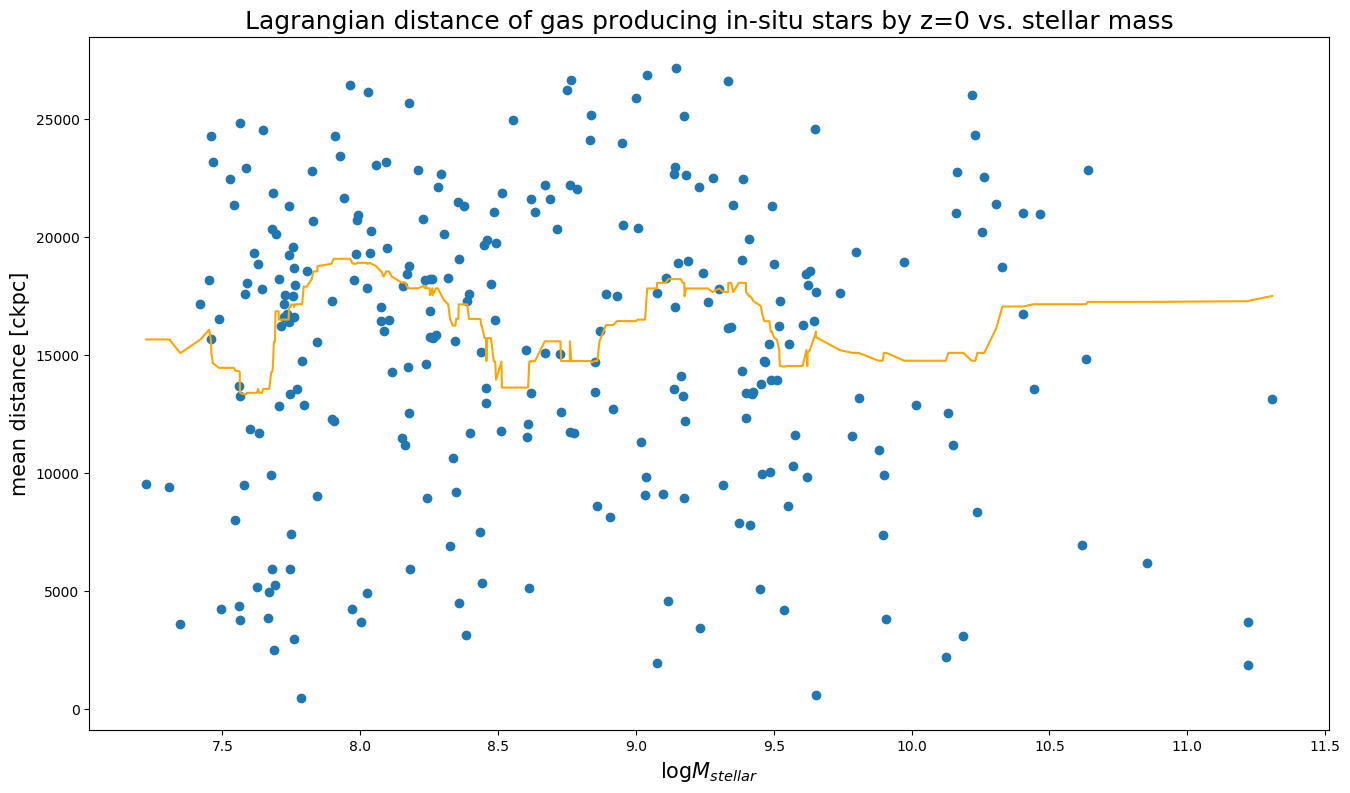

In [51]:
header = il.groupcat.loadHeader(basePath,25)
h_const = header['HubbleParam']

sub_positions = h5py.File('files/'+basePath[32:39]+'/SubhaloPosAtAllSnaps_extrapolated.hdf5','r') 
is_extrapolated = sub_positions['is_extrapolated'][:]
sub_positions.close()

stellar_masses = il.groupcat.loadSubhalos(basePath, 25, fields = ['SubhaloMassType'])[:,4] * 1e10/h_const
stellar_masses = stellar_masses[np.where(is_extrapolated)[0]]
mask = np.where(sub_means4 != 0)[0]
stellar_masses = np.log10(stellar_masses[mask])
sub_means_masked = sub_means4[mask]

plt.scatter(stellar_masses,sub_means_masked)
med = np.array(running_median_insort(sub_means_masked,50))
x = stellar_masses[np.argsort(stellar_masses)]
plt.plot(x,med,color = 'orange')
plt.xlabel('$\log{M_{stellar}}$',size = 15)
plt.ylabel('mean distance [ckpc]',size = 15)
plt.title('Lagrangian distance of gas producing in-situ stars by z=0 vs. stellar mass',size = 18)

In [36]:
def one_gal_profile_vs_redshift(basePath, subID = 0, max_dist = 15000, onlyGas = False):
    start = time.time()
    header = il.groupcat.loadHeader(basePath,99)
    boxSize = header['BoxSize']
    
    f = h5py.File('files/'+basePath[32:39]+'/all_parent_indices.hdf5','r')
    tracers_in_parent_offset = f['snap_099/tracers_in_parents_offset'][:]
    snaps = np.arange(99,11,-1)
    problem = []
    for i in range(99,11,-1):
        if f'snap_0{i}' not in f:
            problem.append(99 - i)
    f.close()
    snaps = np.delete(snaps,problem)
    
    sub_positions = h5py.File('files/' + basePath[32:39] + '/SubhaloPosAtAllSnaps_extrapolated.hdf5','r') 
    sub_pos = sub_positions['SubhaloPos'][subID,:,:]
    sub_positions.close()
    
    end_load = time.time()
    print('time for loading: ',end_load-start)
    
    insituStarsInSubOffset = tF.insituStarsInSubOffset(basePath,99)
    #there might be more tracers -> parents in one galaxy at higher redshifts than insitu stars at redshift 0
    parentsInSubOffset = tF.tracersInSubhalo(insituStarsInSubOffset,tracers_in_parent_offset).astype(int)
    parentsInSubOffset = np.insert(parentsInSubOffset,0,0)
    
    end_offsets = time.time()
    print('time for offsets: ',end_offsets-end_load)
    
    num_bins = 100
    bins = np.linspace(0,max_dist,num_bins)
    num = np.zeros((snaps.size,num_bins))
    z = np.zeros(snaps.size)
    snap_count = 0
    tree = il.sublink.loadTree(basePath,99,subID,fields=['SubfindID'],onlyMPB = True)
    
    for i in range(snaps.size):
    #for i in range(1):        
        all_parent_indices = h5py.File('files/' + basePath[32:39] + '/all_parent_indices.hdf5','r')
        parent_indices = all_parent_indices[f'snap_0{snaps[i]}/parent_indices']\
        [parentsInSubOffset[subID]:parentsInSubOffset[subID+1],:]
        
        all_gas_pos = il.snapshot.loadSubset(basePath, snaps[i], 'gas', fields = ['Coordinates'])
        gas_parent_indices = parent_indices[np.where(parent_indices[:,1] == 0)[0],0]
        gas_pos = all_gas_pos[gas_parent_indices.astype(int)]
        if not onlyGas:
            all_star_pos = il.snapshot.loadSubset(basePath, snaps[i], 'stars', fields = ['Coordinates'])
            star_parent_indices = parent_indices[np.where(parent_indices[:,1] == 1)[0],0]
            star_pos = all_star_pos[star_parent_indices.astype(int)]
        
        end_load2 = time.time()
        #print('time for 2nd loading: ',end_load2-end_offsets)

        #subhalo_position = il.groupcat.loadSubhalos(basePath,snaps[i],fields=['SubhaloPos'])[tree[99-snaps[i]]]#sub_pos[snap_count,:]
        subhalo_position = sub_pos[99-snaps[i]]
        
        rad_dist = np.zeros(gas_pos.shape[0])
        if not onlyGas:
            rad_dist = np.zeros(gas_pos.shape[0] + star_pos.shape[0])
        for j in range(gas_pos.shape[0]):
            rad_dist[j] = iF.dist(subhalo_position,gas_pos[j],boxSize)
        if not onlyGas:
            for j in range(star_pos.shape[0]):
                rad_dist[gas_pos.shape[0] + j] = iF.dist(subhalo_position,star_pos[j],boxSize)
        
        end_prof = time.time()
        #print('time for computing profiles: ',end_prof-end_load2)
        
        num[i,:] = iF.binData_w_bins(rad_dist,bins = bins)
        num[i,:] = num[i,:]/sum(num[i,:]) #we're only interested in the fraction of tracers in that bin
        z[i] = il.groupcat.loadHeader(basePath, snaps[i])['Redshift']
        
        end_bin = time.time()
        #print('time for binning: ',end_bin-end_prof)
    
        print(snaps[i],' done;',end=' ',flush=True)
    all_parent_indices.close()
    return bins, num, z

In [50]:
%%time
basePath = '/virgotng/universe/IllustrisTNG/TNG50-2/output'
bins, num, z = one_gal_profile_vs_redshift(basePath, subID = 0, max_dist = 800, onlyGas = False)

time for loading:  1.1189002990722656
time for offsets:  8.992013692855835
99  done; 98  done; 97  done; 96  done; 95  done; 94  done; 93  done; 92  done; 91  done; 90  done; 89  done; 88  done; 87  done; 86  done; 85  done; 84  done; 83  done; 82  done; 81  done; 80  done; 79  done; 78  done; 77  done; 76  done; 75  done; 74  done; 73  done; 72  done; 71  done; 70  done; 69  done; 68  done; 67  done; 66  done; 65  done; 64  done; 63  done; 62  done; 61  done; 59  done; 58  done; 57  done; 56  done; 55  done; 54  done; 53  done; 52  done; 51  done; 50  done; 49  done; 48  done; 47  done; 46  done; 45  done; 44  done; 43  done; 42  done; 41  done; 40  done; 39  done; 38  done; 37  done; 35  done; 34  done; 27  done; 26  done; 25  done; 24  done; 23  done; 22  done; 21  done; 20  done; 19  done; 18  done; 17  done; 16  done; 15  done; 14  done; 13  done; 12  done; CPU times: user 6min 11s, sys: 11min, total: 17min 11s
Wall time: 2h 15min 21s


In [51]:
# f = h5py.File('files/TNG50-2/rad_prof_z_tracer_frac_sub0-800.hdf5','w')
# ds = f.create_dataset('bins',bins.shape,dtype = float)
# ds[:] = bins
# ds2 = f.create_dataset('redshift',z.shape,dtype = float)
# ds2[:] = z
# ds3 = f.create_dataset('values',num.shape,dtype = float)
# ds3[:] = num
# f.close()

Text(0.5, 1.0, 'evolution of radial profile of mass fraction')

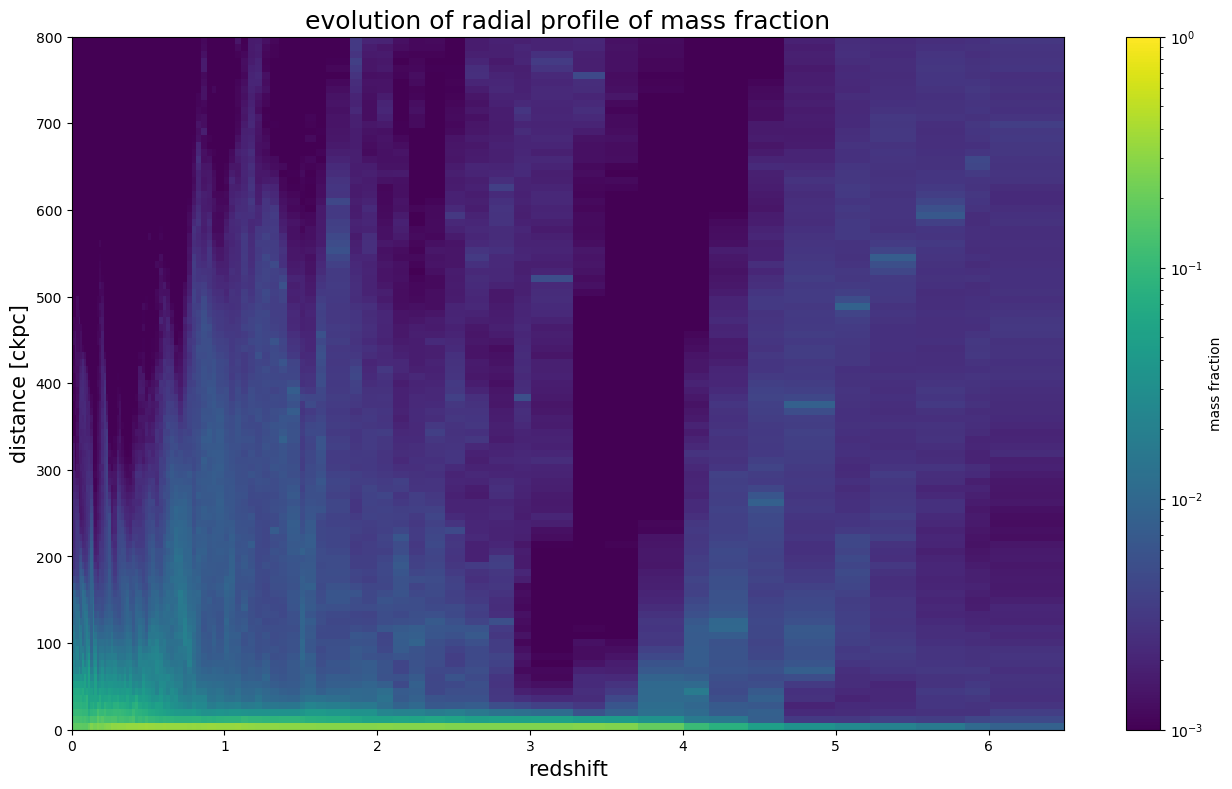

In [54]:
plt.pcolormesh(z,bins,num.T,norm = mpl.colors.LogNorm(1e-3,1), shading='auto')
plt.colorbar(label='mass fraction')
plt.ylabel('distance [ckpc]',size=15)
plt.xlabel('redshift',size=15)
plt.title('evolution of radial profile of mass fraction',size=18)
#plt.savefig('pics/rad_prof_z_tracer_frac_sub0_TNG50-2-800.jpg',format='jpg')